In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('/content/modified_ais_data.csv',nrows=10000)

In [3]:
df.head()

,BaseDateTime,MMSI,IMO,LAT,LON,SOG,COG
0,2022-03-31T00:00:01,671226100,IMO9221322,25.77626,-80.20320,3.2,143.7
1,2022-03-31T00:00:06,367452810,IMO9602344,29.32824,-94.77391,2.6,319.2
2,2022-03-31T00:00:09,366919770,IMO9253583,48.74428,-122.49504,0.0,210.3
3,2022-03-31T00:00:00,311000966,IMO8916607,18.55833,-66.47910,17.5,274.5
4,2022-03-31T00:00:01,219028420,IMO9411305,28.66703,-93.59339,9.5,129.4


In [4]:
import math

def lat_lon_to_cartesian(lat, lon, R=6371):
    lat_rad = math.radians(lat)
    lon_rad = math.radians(lon)
    x = R * math.cos(lat_rad) * math.cos(lon_rad)
    y = R * math.cos(lat_rad) * math.sin(lon_rad)
    z = R * math.sin(lat_rad)
    return x, y, z

def cartesian_to_lat_lon(x, y, z, R=6371):
    lon = math.degrees(math.atan2(y, x))
    lat = math.degrees(math.asin(z / R))
    return lat, lon


In [5]:
df[['x', 'y', 'z']] = df.apply(lambda row: pd.Series(lat_lon_to_cartesian(row['LAT'], row['LON'])), axis=1)

In [6]:
df.head()

,BaseDateTime,MMSI,IMO,LAT,LON,SOG,COG,x,y,z
0,2022-03-31T00:00:01,671226100,IMO9221322,25.77626,-80.20320,3.2,143.7,976.189651,-5653.417795,2770.480464
1,2022-03-31T00:00:06,367452810,IMO9602344,29.32824,-94.77391,2.6,319.2,-462.261129,-5535.146877,3120.593645
2,2022-03-31T00:00:09,366919770,IMO9253583,48.74428,-122.49504,0.0,210.3,-2256.980451,-3543.426543,4789.552023
3,2022-03-31T00:00:00,311000966,IMO8916607,18.55833,-66.47910,17.5,274.5,2410.348516,-5537.896973,2027.697745
4,2022-03-31T00:00:01,219028420,IMO9411305,28.66703,-93.59339,9.5,129.4,-350.359001,-5579.067584,3056.287693


In [7]:
import numpy as np
def haversine(lat1, lon1, lat2, lon2, R=6371):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

In [8]:
df["BaseDateTime"] = pd.to_datetime(df["BaseDateTime"])

In [9]:
def calculate_distances(group):
    group = group.sort_values(by="BaseDateTime")
    group["next_lat"] = group["LAT"].shift(-1)
    group["next_long"] = group["LON"].shift(-1)
    group["distance_km"] = group.apply(
        lambda row: haversine(row["LAT"], row["LON"], row["next_lat"], row["next_long"])
        if not np.isnan(row["next_lat"])
        else 0,
        axis=1,
    )
    return group.drop(columns=["next_lat", "next_long"])

In [10]:
df = df.groupby("MMSI").apply(calculate_distances).reset_index(drop=True)
df.head()

<ipython-input-10-e18fd20cbb70>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("MMSI").apply(calculate_distances).reset_index(drop=True)


,BaseDateTime,MMSI,IMO,LAT,LON,SOG,COG,x,y,z,distance_km
0,2022-03-31 00:02:32,111,IMO0000001,27.35372,-94.62546,0.4,228.6,-456.323030,-5640.208831,2927.363085,0.003950
1,2022-03-31 00:05:35,111,IMO0000001,27.35372,-94.62550,0.6,219.8,-456.326968,-5640.208513,2927.363085,0.008126
2,2022-03-31 00:08:34,111,IMO0000001,27.35377,-94.62556,0.2,221.7,-456.332668,-5640.205489,2927.368023,0.000000
3,2022-03-31 00:00:17,1056261,IMO1056261,26.11809,-80.14815,0.1,220.5,978.775466,-5636.091653,2804.658708,0.000998
4,2022-03-31 00:01:18,1056261,IMO1056261,26.11809,-80.14814,0.0,211.7,978.776450,-5636.091482,2804.658708,0.001997


In [11]:
def calculate_durations(group):
    # Ensure BaseDateTime is a datetime type
    group['BaseDateTime'] = pd.to_datetime(group['BaseDateTime'])
    # Calculate the duration between consecutive points in seconds
    group['duration_seconds'] = group['BaseDateTime'].diff().dt.total_seconds()
    return group

In [12]:
df = df.groupby("MMSI", group_keys=False).apply(calculate_durations)
df = df.reset_index(drop=True)
df.head()

<ipython-input-12-1fbd24d56e1c>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("MMSI", group_keys=False).apply(calculate_durations)


,BaseDateTime,MMSI,IMO,LAT,LON,SOG,COG,x,y,z,distance_km,duration_seconds
0,2022-03-31 00:02:32,111,IMO0000001,27.35372,-94.62546,0.4,228.6,-456.323030,-5640.208831,2927.363085,0.003950,NaN
1,2022-03-31 00:05:35,111,IMO0000001,27.35372,-94.62550,0.6,219.8,-456.326968,-5640.208513,2927.363085,0.008126,183.0
2,2022-03-31 00:08:34,111,IMO0000001,27.35377,-94.62556,0.2,221.7,-456.332668,-5640.205489,2927.368023,0.000000,179.0
3,2022-03-31 00:00:17,1056261,IMO1056261,26.11809,-80.14815,0.1,220.5,978.775466,-5636.091653,2804.658708,0.000998,NaN
4,2022-03-31 00:01:18,1056261,IMO1056261,26.11809,-80.14814,0.0,211.7,978.776450,-5636.091482,2804.658708,0.001997,61.0


In [13]:
# Define constants
KNOTS_TO_METERS_PER_SEC = 0.514444
df['sog_mps'] = df['SOG'].apply(lambda x: x * KNOTS_TO_METERS_PER_SEC)
df['cog_radians'] = df['COG'].apply(lambda x: np.radians(x))


In [14]:
import pandas as pd
import numpy as np

# Define the function to calculate magnitude
def calculate_magnitude(df):
    # Calculate the velocity components
    df['v_x'] = df['sog_mps'] * np.cos(df['cog_radians'])
    df['v_y'] = df['sog_mps'] * np.sin(df['cog_radians'])

    # Calculate the magnitude
    df['magnitude'] = np.sqrt(df['v_x']**2 + df['v_y']**2)

    # Drop the v_x and v_y columns
    df.drop(columns=['v_x', 'v_y'], inplace=True)

    return df

# Apply the function
df = calculate_magnitude(df)


In [15]:
df.head()

,BaseDateTime,MMSI,IMO,LAT,LON,SOG,COG,x,y,z,distance_km,duration_seconds,sog_mps,cog_radians,magnitude
0,2022-03-31 00:02:32,111,IMO0000001,27.35372,-94.62546,0.4,228.6,-456.323030,-5640.208831,2927.363085,0.003950,NaN,0.205778,3.989823,0.205778
1,2022-03-31 00:05:35,111,IMO0000001,27.35372,-94.62550,0.6,219.8,-456.326968,-5640.208513,2927.363085,0.008126,183.0,0.308666,3.836234,0.308666
2,2022-03-31 00:08:34,111,IMO0000001,27.35377,-94.62556,0.2,221.7,-456.332668,-5640.205489,2927.368023,0.000000,179.0,0.102889,3.869395,0.102889
3,2022-03-31 00:00:17,1056261,IMO1056261,26.11809,-80.14815,0.1,220.5,978.775466,-5636.091653,2804.658708,0.000998,NaN,0.051444,3.848451,0.051444
4,2022-03-31 00:01:18,1056261,IMO1056261,26.11809,-80.14814,0.0,211.7,978.776450,-5636.091482,2804.658708,0.001997,61.0,0.000000,3.694862,0.000000


In [16]:
df = df[['x','y','z','duration_seconds','distance_km','sog_mps','cog_radians',
         'magnitude']]

In [17]:
df.head()

,x,y,z,duration_seconds,distance_km,sog_mps,cog_radians,magnitude
0,-456.323030,-5640.208831,2927.363085,NaN,0.003950,0.205778,3.989823,0.205778
1,-456.326968,-5640.208513,2927.363085,183.0,0.008126,0.308666,3.836234,0.308666
2,-456.332668,-5640.205489,2927.368023,179.0,0.000000,0.102889,3.869395,0.102889
3,978.775466,-5636.091653,2804.658708,NaN,0.000998,0.051444,3.848451,0.051444
4,978.776450,-5636.091482,2804.658708,61.0,0.001997,0.000000,3.694862,0.000000


In [18]:
df.dropna(inplace=True)

<ipython-input-18-c64f9f573c18>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


In [19]:
df.head()

,x,y,z,duration_seconds,distance_km,sog_mps,cog_radians,magnitude
1,-456.326968,-5640.208513,2927.363085,183.0,0.008126,0.308666,3.836234,0.308666
2,-456.332668,-5640.205489,2927.368023,179.0,0.000000,0.102889,3.869395,0.102889
4,978.776450,-5636.091482,2804.658708,61.0,0.001997,0.000000,3.694862,0.000000
5,978.778417,-5636.091140,2804.658708,78.0,0.003994,0.000000,3.801327,0.000000
6,978.774482,-5636.091823,2804.658708,71.0,0.001494,0.000000,3.885103,0.000000


### Model

In [25]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, MultiHeadAttention, LayerNormalization, Dropout,
    TimeDistributed, Masking
)
from sklearn.preprocessing import MinMaxScaler

# --------------------------- MASKING FUNCTIONS ---------------------------

# def create_look_ahead_mask(seq_len):
#     """Generates an upper triangular matrix filled with -inf to mask future tokens."""
#     mask = np.triu(np.ones((seq_len, seq_len)), k=1)  # Upper triangular (excluding diagonal)
#     return tf.convert_to_tensor(mask * -1e9)  # Convert to large negative values

def create_look_ahead_mask(seq_len):
    return tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0) * -1e9

def create_padding_mask(seq):
    """Creates a mask where 1s indicate padding tokens (timesteps with all features zero)."""
    # seq shape: (batch_size, seq_len, feature_dim)
    # mask = tf.reduce_all(tf.math.equal(seq, 0), axis=-1)  # (batch_size, seq_len)
    mask = tf.reduce_all(tf.math.equal(seq, -1), axis=-1)
    mask = tf.cast(mask, tf.float32)  # 1.0 where padding, 0.0 otherwise
    return mask[:, tf.newaxis, tf.newaxis, :]  # Shape: (batch, 1, 1, seq_len)

# ------------------------- POSITIONAL ENCODING -------------------------

# class PositionalEncoding(tf.keras.layers.Layer):
#     def __init__(self, d_model, **kwargs):
#         super(PositionalEncoding, self).__init__(**kwargs)
#         self.d_model = d_model

#     def call(self, inputs):
#         seq_len = tf.shape(inputs)[1]
#         pos = tf.range(seq_len, dtype=tf.float32)[:, tf.newaxis]
#         i = tf.range(self.d_model, dtype=tf.float32)[tf.newaxis, :]
#         angle_rates = 1 / tf.pow(10000.0, (2 * (i // 2)) / tf.cast(self.d_model, tf.float32))

#         angle_rads = pos * angle_rates  # Shape: (seq_len, d_model)

#         # Apply sin to even indices and cos to odd indices
#         sin_mask = tf.cast(tf.math.equal(i % 2, 0), tf.float32)
#         cos_mask = tf.cast(tf.math.equal(i % 2, 1), tf.float32)

#         pe = tf.sin(angle_rads) * sin_mask + tf.cos(angle_rads) * cos_mask
#         return inputs + pe

class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model

        # Compute positional encodings
        pos = np.arange(max_len)[:, np.newaxis]
        div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
        pe = np.zeros((max_len, d_model))
        pe[:, 0::2] = np.sin(pos * div_term)
        pe[:, 1::2] = np.cos(pos * div_term)
        self.positional_encoding = tf.convert_to_tensor(pe[np.newaxis, :, :], dtype=tf.float32)

    def call(self, x):
        seq_len = tf.shape(x)[1]
        return x + self.positional_encoding[:, :seq_len, :]

# ------------------------- ENCODER LAYER -------------------------

class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, num_heads, d_model, ff_dim, dropout_rate=0.1):
        super(EncoderLayer, self).__init__()
        self.mha = MultiHeadAttention(num_heads=num_heads, key_dim=d_model // num_heads)
        self.norm1 = LayerNormalization(epsilon=1e-6)
        self.norm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(dropout_rate)
        self.dropout2 = Dropout(dropout_rate)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(d_model)
        ])

    def call(self, inputs, padding_mask):
        attn_output = self.mha(inputs, inputs, attention_mask=padding_mask)
        attn_output = self.dropout1(attn_output)
        out1 = self.norm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.norm2(out1 + ffn_output)

# ------------------------- DECODER LAYER -------------------------

class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, num_heads, d_model, ff_dim, dropout_rate=0.1):
        super(DecoderLayer, self).__init__()
        self.mha1 = MultiHeadAttention(num_heads=num_heads, key_dim=d_model // num_heads)
        self.mha2 = MultiHeadAttention(num_heads=num_heads, key_dim=d_model // num_heads)
        self.norm1 = LayerNormalization(epsilon=1e-6)
        self.norm2 = LayerNormalization(epsilon=1e-6)
        self.norm3 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(dropout_rate)
        self.dropout2 = Dropout(dropout_rate)
        self.dropout3 = Dropout(dropout_rate)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(d_model)
        ])

    def call(self, inputs, encoder_outputs, combined_mask, padding_mask):
        # Self-attention with combined mask (look-ahead + padding)
        attn1 = self.mha1(inputs, inputs, attention_mask=combined_mask)
        attn1 = self.dropout1(attn1)
        out1 = self.norm1(inputs + attn1)
        # Encoder-decoder attention
        attn2 = self.mha2(out1, encoder_outputs, attention_mask=padding_mask)
        attn2 = self.dropout2(attn2)
        out2 = self.norm2(out1 + attn2)
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output)
        return self.norm3(out2 + ffn_output)

# ------------------------- BUILD TRANSFORMER -------------------------

from tensorflow.keras.layers import Lambda

def build_transformer(input_shape, target_shape, num_layers=4, num_heads=4, d_model=16, ff_dim=64):
    encoder_inputs = Input(shape=input_shape, name="encoder_inputs")
    decoder_inputs = Input(shape=target_shape, name="decoder_inputs")

    # Encoder masks
    enc_padding_mask = Lambda(lambda x: create_padding_mask(x))(encoder_inputs)

    # Decoder masks
    dec_padding_mask = Lambda(lambda x: create_padding_mask(x))(decoder_inputs)
    # look_ahead_mask = Lambda(lambda x: create_look_ahead_mask(target_shape[0]))(decoder_inputs)
    look_ahead_mask = Lambda(lambda x: create_look_ahead_mask(tf.shape(x)[1]))(decoder_inputs)
    combined_mask = Lambda(lambda x: tf.maximum(x[0], x[1]))([look_ahead_mask, dec_padding_mask])

    # Encoder
    x = Masking(mask_value=0.0)(encoder_inputs)
    x = PositionalEncoding(d_model)(x)
    for _ in range(num_layers):
        x = EncoderLayer(num_heads, d_model, ff_dim)(x, enc_padding_mask)
    encoder_outputs = x

    # Decoder
    x = Masking(mask_value=0.0)(decoder_inputs)
    x = PositionalEncoding(d_model)(x)
    for _ in range(num_layers):
        x = DecoderLayer(num_heads, d_model, ff_dim)(x, encoder_outputs, combined_mask, enc_padding_mask)

    outputs = TimeDistributed(Dense(target_shape[-1], activation="linear"))(x)
    return Model([encoder_inputs, decoder_inputs], outputs)

# ------------------------- TRAINING -------------------------

# Simulated dataset
feature_dim = 8
seq_length = 10

# Create Transformer model
model = build_transformer(
    (seq_length, feature_dim),
    (seq_length, feature_dim),
    num_layers=4,
    num_heads=4,
    d_model=feature_dim,
    ff_dim=64
)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="mse", metrics=['accuracy'])

# Normalize Data
train_size = int(len(df) * 0.8)
train_data, test_data = df.iloc[:train_size], df.iloc[train_size:]

scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_data)
scaled_test = scaler.transform(test_data)


def create_sequences(data, seq_length):
    X, decoder_inputs, decoder_targets = [], [], []
    for i in range(len(data) - 2 * seq_length + 1):
        X.append(data[i:i + seq_length])
        start_token = data[i + seq_length - 1]
        decoder_in = np.vstack([
            start_token,
            data[i + seq_length:i + seq_length + seq_length - 1]
        ])
        decoder_target = data[i + seq_length:i + seq_length + seq_length]
        decoder_inputs.append(decoder_in)
        decoder_targets.append(decoder_target)
    return np.array(X), np.array(decoder_inputs), np.array(decoder_targets)


X_train, decoder_inputs_train, decoder_targets_train = create_sequences(scaled_train, seq_length)
X_test, decoder_inputs_test, decoder_targets_test = create_sequences(scaled_test, seq_length)

# Train model
model.fit(
    [X_train, decoder_inputs_train],
    decoder_targets_train,
    validation_data=([X_test, decoder_inputs_test], decoder_targets_test),
    epochs=10,
    batch_size=32
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'positional_encoding_3' (of type PositionalEncoding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'positional_encoding_4' (of type PositionalEncoding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'positional_encoding_3' (of type PositionalEncoding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'positional_encoding_4' (of type PositionalEncoding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


200/200 ━━━━━━━━━━━━━━━━━━━━ 52s 61ms/step - accuracy: 0.3784 - loss: 0.1273 - val_accuracy: 0.5943 - val_loss: 0.0280
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 20s 60ms/step - accuracy: 0.5447 - loss: 0.0293 - val_accuracy: 0.6503 - val_loss: 0.0232
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 22s 64ms/step - accuracy: 0.6452 - loss: 0.0226 - val_accuracy: 0.6988 - val_loss: 0.0189
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 18s 51ms/step - accuracy: 0.7054 - loss: 0.0191 - val_accuracy: 0.7388 - val_loss: 0.0175
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - accuracy: 0.7304 - loss: 0.0179 - val_accuracy: 0.7410 - val_loss: 0.0168
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.7329 - loss: 0.0169 - val_accuracy: 0.7452 - val_loss: 0.0165
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.7371 - loss: 0.0164 - val_accuracy: 0.7461 - val_loss: 0.0163
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step - accuracy: 0.7375 - loss: 0.0158 - val_accuracy

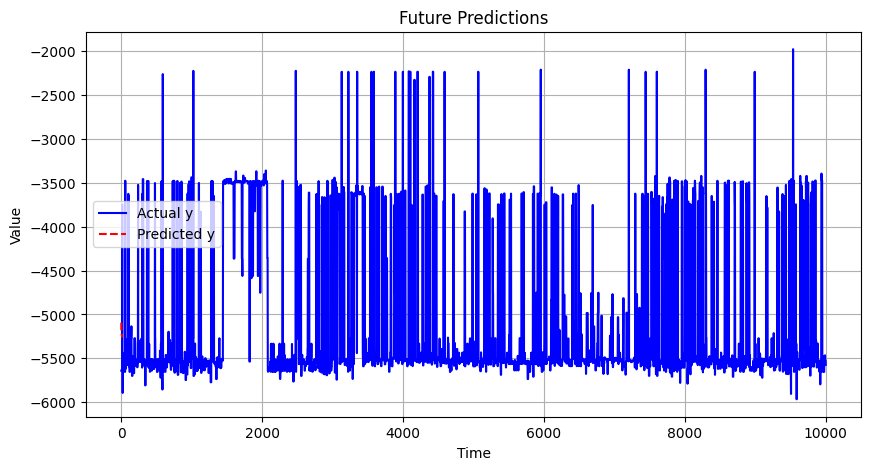

In [26]:
# 🔹 Apply Positional Encoding
d_model = X_train.shape[2]
pos_encoding_layer = PositionalEncoding(d_model)

encoder_input_pos_encoded = pos_encoding_layer(encoder_input)
decoder_input_pos_encoded = pos_encoding_layer(decoder_input)

# 🔹 Future Predictions Loop
for step in range(future_steps):
    # Predict next step
    pred = model.predict([encoder_input_pos_encoded, decoder_input_pos_encoded], verbose=0)

    # Extract last predicted time step
    next_pred = pred[0, -1, :]

    # Store prediction
    future_predictions.append(next_pred)

    # Shift decoder input & insert new prediction
    decoder_input = np.roll(decoder_input, -1, axis=1)
    decoder_input[0, -1, :] = next_pred

    # Apply Positional Encoding to updated decoder input
    decoder_input_pos_encoded = pos_encoding_layer(decoder_input)

# 🔹 Convert Predictions to DataFrame
future_predictions = np.array(future_predictions)
future_predictions = scaler.inverse_transform(future_predictions)  # Convert back to original scale

expected_columns = df.columns[:future_predictions.shape[1]]  # Ensure correct column count
forecast_df = pd.DataFrame(future_predictions, columns=expected_columns)

# 🔹 Plot Actual vs. Predicted Values
plt.figure(figsize=(10, 5))
plt.plot(df["y"], label="Actual y", color="blue")  # Replace "y" with actual target column
plt.plot(forecast_df["y"], label="Predicted y", color="red", linestyle="dashed")  # Replace "y" with actual target
plt.legend()
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Future Predictions")
plt.grid()
plt.show()